## 1. Procurando por 'Ouro' em arquivos HTML
<p>Costumava levar dias para que as notícias financeiras se espalhassem por rádio, jornais e boca-a-boca. Agora, na era da internet, leva segundos. Nos dias de hoje, Fundos de hedge e traders independentes estão usando a Data Science para processar essa riqueza de informações em busca de lucro.</p>
<p>Neste notebook iremos gerar insights sobre investimentos aplicando <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">análise de sentimento</a> em manchetes de notícias financeiras de <a href=" https://finviz.com">FINVIZ.com</a>. Usando a técnica de NLP - processamento de linguagem natural - podemos entender a emoção por trás das manchetes e prever se o mercado <em>se sente</a> em> bom ou ruim sobre uma determinada ação. Seria então possível fazer suposições sobre o desempenho de certas ações e negociar de acordo.</p>
<p><img src="https://assets.datacamp.com/production/project_611/img/fb_headlines.png" alt="Manchetes do Facebook de FINVIZ.com"></p>
<p>Por que manchetes? E por que da FINVIZ?</p>
<ol>
<li>Títulos, que têm tamanho semelhante, são mais fáceis de analisar e agrupar do que artigos completos, que variam em tamanho.</li>
<li>FINVIZ tem uma lista de sites confiáveis, e os títulos desses sites tendem a ser mais consistentes em seu jargão do que os de blogueiros independentes. Padrões textuais consistentes melhorarão a análise de sentimentos.</li>
</ol>
<p>Como <a href="https://en.wikipedia.org/wiki/Web_scraping">web scraping</a> requer ética em Dat Science (enviar muito tráfego para os servidores de um FINVIZ não é muito bom) , os arquivos HTML para Facebook e Tesla de vários períodos foram baixados. Vamos fazer a importação desses arquivos.</p>
<p><strong>Isenção de responsabilidade: Investir no mercado de ações envolve risco e pode levar a perdas monetárias. O conteúdo deste notebook não deve ser considerado como aconselhamento financeiro.</strong> </p>

In [41]:
# Importando as bibliotecas
from bs4 import BeautifulSoup # Pacote para análise de documentos HTML e XML
import os


html_tables = {}

# Para cada tabela no diretório dos datasets
for table_name in os.listdir('datasets'):
    #localização do arquivo
    table_path = f'datasets/{table_name}'
    # Abrindo um arquivo Python em modo 'somente-leitura'
    table_file = open(table_path, 'r')
    # Lendo o conteúdo do arquivo em 'html'
    html = BeautifulSoup(table_file)
    # Procurando por 'news-table' e carregando-o em 'html_table'
    html_table = html.find(id='news-table')
    # Adicionando a tabela para o nosso dicionário
    html_tables[table_name] = html_table

## 2. O que há dentro desses arquivos?
<p>Pegamos a tabela que contém as manchetes do arquivo HTML de cada ação mas, antes de começarmos a analisar essas tabelas, precisamos entender como seus dados estão estruturados. 

In [42]:
# Lendo um único dia das manchetes
tsla = html_tables['tsla_22sep.html']
# Obtendo todas as linhas da tabela marcadas em HTML com <tr> e atribuindo à 'tsla_tr'
tsla_tr = tsla.findAll('tr')

# Para cada coluna:
for i, table_row in enumerate(tsla_tr):
    # Lendo o texto do elemento html 'a' em 'link_text'
    link_text = table_row.a.get_text()
    # Lendo o texto do elemento html 'td' em, 'data_text'
    data_text = table_row.td.get_text()
    # Imprimindo a contagem
    print(f'File number {i+1}:')
    # Imprimindo o conteúdo de 'link_text' e 'data_text' 
    print(link_text)
    print(data_text)
    # Saíndo do 'loop' depois de quatro linhas para prevenir 'spamming' no notebook
    if i == 3:
        break

File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3. Extraindo as novas manchetes
<p>Como vimos acima, os dados interessantes dentro de cada linha da tabela (<code>&lt;tr&gt;</code>) estão no texto dentro das tags <code>&lt;td&gt;</code> e <code>&lt;a&gt;</code>. Iremos agora analisar os dados de <strong>todas</strong> tabelas em uma estrutura de dados adequada.</p>


In [43]:
# Mantendo as noticias analisadas em uma lista
parsed_news = []
# Iterando através das notícias
for file_name, news_table in html_tables.items():
    # Iterando sobre todas as tags 'tr' em 'news_table
    for x in news_table.findAll('tr'):
        # Lendo o texto de 'tr' e atribuíndo à 'text'
        text = x.get_text() 
        # Dividindo o texto na tag 'td' e atribuíndo a uma lista
        date_scrape = x.td.text.split()
        # Se o comprimento de 'date_scrape' for 1, carregar 'time' como o único elemento
        # Se não, carregar 'date' como o primeiro elemento e 'time' como o segundo
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extraíndo o marcador do nome do arquivo, pegando a  string até o primeiro '_'  
        ticker = file_name.split('_')[0]
        # Anexando 'ticker', 'date', 'time' e 'headline' como uma lista para a lista 'parsed_news'
        parsed_news.append([ticker, date, time, x.a.text])

## 4. Fazendo com que a NLTK pense como um jornalista financeiro
<p>A análise de sentimentos é muito sensível ao contexto. Por exemplo, dizer <em>"Isso é tão viciante!"</em> geralmente significa algo positivo se o contexto for um videogame que você está curtindo com seus amigos, mas muitas vezes significa algo negativo quando estamos falando de remédios para dor. Lembre-se de que a razão pela qual escolhemos as manchetes é para tentarmos extrair o sentimento dos jornalistas financeiros que, como a maioria dos profissionais, têm sua própria linguagem. Vamos agora fazer o NLTK pensar como um jornalista financeiro adicionando algumas novas palavras e valores de sentimento ao nosso léxico.</p>


In [44]:
# Importando NLTK VADER para análise de sentimento
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Baixando o léxico 'vader_lexicon'
#nltk.download('vader_lexicon')

# Novas palavras e valores
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instanciando o 'sentiment intensity analyzer' com o léxico já existente
vader = SentimentIntensityAnalyzer()
# Atualizando o léxico
vader.lexicon.update(new_words)

## 5. ÚLTIMAS NOTÍCIAS: NLTK esmaga estimativas de sentimento
<p>Agora que temos os dados e o algoritmo carregados, chegaremos ao principal da questão: prever programaticamente o sentimento das manchetes das notícias. Felizmente, para nós, VADER é de nível muito alto, portanto, neste caso, não ajustaremos o modelo mais<sup>*</sup> além das adições no léxico feitas anteriormente.</p>
<p><sup>*</sup>VADER "out-of-the-box" com algum léxico extra provavelmente se traduziria em <strong>perdas pesadas</strong> com dinheiro real. Uma ferramenta real de análise de sentimentos com chances de ser lucrativa exigiria um léxico muito extenso e dedicado às notícias financeiras. Além disso, também pode não ser suficiente usar um modelo "pré-moldado" como o VADER.</p>

In [45]:
import pandas as pd
# Usaremos as seguintes colunas
columns = ['ticker', 'date', 'time', 'headline']
# Convertendo listas de listas em um DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterando através das manchetes para obter os 'polarity scores'
scores = [vader.polarity_scores(headline) for headline in scored_news.headline]
# Convertendo listas de dicionários em um DataFrame
scores_df = pd.DataFrame(scores)
scored_news.columns = columns
# Juntando os DataFrames
scored_news = scored_news.join(scores_df)
# Convertendo a coluna 'date' de 'string' para 'datetime'
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

## 6. Plotando todos os sentimentos em subplots
<p>Agora que temos as pontuações, vamos plotar os resultados. Começaremos plotando a 'time series' para as ações que temos</p>



<AxesSubplot:xlabel='date'>

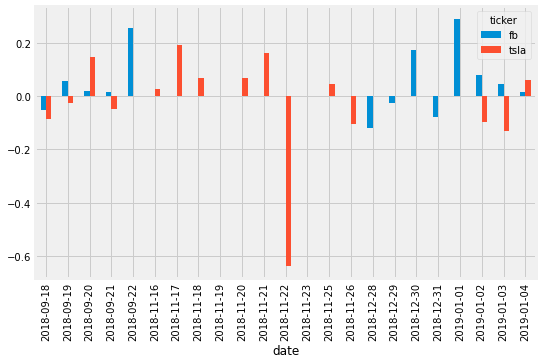

In [46]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Agrupando pelas colunas 'date' e 'ticker' de 'scored_news' e calculando a média
mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstacking a coluna 'ticker'
mean_c = mean_c.unstack('ticker')
# Obtendo a seção 'transversal' do composto no eixo 'columns'
mean_c = mean_c.xs('compound', axis='columns')
# Plotando um  'bar chart' com Pandas
mean_c.plot.bar(figsize = (8, 5))

## 7. Fins de semana e duplicatas
<p>O que aconteceu com Tesla na data de 22 de novembro? Como temos as manchetes dentro de nosso <code>DataFrame</code>, uma olhada rápida revela a existência de alguns problemas nesse dia específico: </p>
<ul>
<li>Há apenas 5 manchetes para esse dia.</li>
<li>Duas manchetes são literalmente iguais a outra, mas de outra agência de notícias.</li>
</ul>
<p>Vamos limpar um pouco o conjunto de dados, mas não muito. Embora algumas manchetes sejam a mesma notícia de fontes diferentes, o fato de serem escritas de maneira diferente pode fornecer perspectivas diferentes sobre a mesma história. Além disso, quando uma notícia é mais importante, ela tende a receber mais manchetes de várias fontes. O que queremos eliminar são as manchetes copiadas na íntegra pois provavelmente são do mesmo jornalista e estão apenas sendo "encaminhadas", por assim dizer.</p>

In [47]:
# Contando o número de manchetes em 'scored_news' (salvar como int)
num_news_before = scored_news.headline.count()
# Retirando duplicatas em 'ticker' e 'headline'
scored_news_clean = scored_news.drop_duplicates(subset=['ticker', 'headline'])
# Contando o número de manchetes depois da retirada das duplicatas
num_news_after = scored_news_clean.headline.count()
# Imprimindo os números de antes e depois para ter uma idéia de como fizemos
f"Before we had {num_news_before} headlines, now we have {num_news_after}"
print(num_news_before)
print(num_news_after)

500
476


## 8. Sentimento em um único dia de trading de uma única ação
<p>Para entender as possibilidades desse dataset e ter uma ideia melhor sobre os dados, iremos focar 
em um único dia e a ação de uma única empresa. Faremos um gráfico informativo onde poderemos ver a menor "granulação" possível: headline e subscores.</p>


In [48]:
# Setando o índice para 'ticker' e 'date'
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section da linha do 'FB'
single_day = single_day.xs('fb', axis='rows')
single_day.head()
# Selecionando o período de '3 de Janeiro de 2019'
single_day = single_day.loc['2019-01-03']
# Convertendo a string 'datetime' para apenas 'time'
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Setando o índice para 'time'
single_day = single_day.set_index('time')
# Organizando o índice
single_day = single_day.sort_index()

KeyError: '2019-01-03'

## 9. Visualizando um único dia
<p>Faremos um gráfico para visualizar as pontuações positivas, negativas e neutras para um único dia de "trading" e uma única ação.

In [49]:
TITLE = "Sentimentos negativo, neutro e positivo para FB em 03/01/2019"
COLORS = ["red","orange", "green"]
# Retirando as colunas que não são úteis para o gráfico
plot_day = single_day.drop(['compound', 'headline'], axis=1)
# Mudando o nome das colunas para 'negativo', 'positivo' e 'neutro'
plot_day.columns = ['negativo', 'neutro', 'positivo']
# Plotando um 'stacked bar' chart
plot_day.plot.bar(stacked = True, figsize = (12, 8), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel('scores');       

                                                                                                        

ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements